In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from skimage.metrics import structural_similarity as ssim
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.decomposition import MiniBatchDictionaryLearning
from tqdm import tqdm
import matplotlib.pyplot as plt
import gym
from gym import spaces
from gym.utils import seeding
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory


In [2]:
import tensorflow as tf

# Check if TensorFlow can access the GPU
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPU is available")
else:
    print("GPU is NOT available")

GPU is available


In [3]:
def learn_dictionary_from_digits():
    """
    Load the digits dataset and learn an over-determined dictionary from it using MiniBatchDictionaryLearning.
    
    Returns:
        dictionary: numpy array
            The learned dictionary.
        dict_learner: MiniBatchDictionaryLearning object
            The trained dictionary learner.
    """
    # Load the digits dataset
    digits = load_digits()
    images = digits.data
    
    # Set the number of components (atoms) for the dictionary to ensure it's over-determined
    n_components = 100  # Greater than 64 (the dimensionality of the input data)
    
    # Use MiniBatchDictionaryLearning to learn a dictionary
    dict_learner = MiniBatchDictionaryLearning(n_components=n_components, alpha=1, random_state=0, n_jobs=-1, transform_algorithm='omp',)
    dictionary = dict_learner.fit(images).components_
    
    return dictionary, dict_learner

# Execute the function to get the learned dictionary and the dictionary learner object
dictionary, dict_learner = learn_dictionary_from_digits()
print(dictionary.shape)


(100, 64)


In [4]:
def reconstruct_with_OMP(dictionary, images, dict_learner):
    """
    Reconstruct the dataset using MiniBatchDictionaryLearning's transform method and a given dictionary.
    
    Args:
        dictionary: numpy array
            The learned dictionary.
        images: numpy array
            The dataset to be reconstructed.
        dict_learner: MiniBatchDictionaryLearning object
            The trained dictionary learner.
    
    Returns:
        reconstructed: numpy array
            The reconstructed dataset.
    """
    # Get the sparse representation of the images using the dictionary learner
    coefficients = dict_learner.transform(images)

    # print(coefficients.shape)
    dictionary = dictionary
    
    # Reconstruct the images from the coefficients and the dictionary
    reconstructed = np.dot(coefficients, dictionary)
    return reconstructed


In [5]:

def average_ssim(original, reconstructed):
    """
    Compute the average SSIM between the original and reconstructed datasets.
    
    Args:
        original: numpy array
            The original dataset.
        reconstructed: numpy array
            The reconstructed dataset.
    
    Returns:
        avg_ssim: float
            The average SSIM value.
    """
    ssim_values = [ssim(original[i].reshape(8, 8), reconstructed[i].reshape(8, 8), data_range=16) for i in range(original.shape[0])]
    return np.mean(ssim_values)


In [6]:

# Load the dataset and dictionary
digits = load_digits()
images = digits.data
dictionary, dict_learner = learn_dictionary_from_digits()


# Test OMP

In [7]:

# Reconstruct the dataset using OMP
reconstructed_images = reconstruct_with_OMP(dictionary, images, dict_learner)

# Evaluate the average SSIM
avg_ssim_value = average_ssim(images, reconstructed_images)
print(f"Average SSIM: {avg_ssim_value}")

Average SSIM: 0.9530500921899188


# NMP

In [8]:


# Load the dataset and dictionary
digits = load_digits()
images = digits.data
dictionary, dict_learner = learn_dictionary_from_digits()
# Define the RL environment

class OMPEnvironment(gym.Env):
    """
    A Reinforcement Learning environment that implements Orthogonal Matching Pursuit (OMP) algorithm for sparse coding.
    
    Attributes:
        dictionary (np.array): The dictionary matrix for sparse coding.
        image (np.array): The input image data to be reconstructed.
        num_atoms (int): The number of atoms in the dictionary.
        observation_space (gym.spaces.Box): The observation space representing the selected atoms.
        action_space (gym.spaces.Discrete): The action space (0 for OMP, 1 for alternative strategy).
        residual (np.array): The current residual of the input image.
        selected_indices (list): The indices of the selected atoms from the dictionary.
        approximated_signals (list): The list of approximated signals at each step.
    """
    def __init__(self, dictionary, y):
        self.dictionary = dictionary
        self.y = y
        self.num_atoms = dictionary.shape[1]
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.num_atoms,))
        self.residual = y
        self.approximated_signals = []
        self.action_space = spaces.Discrete(2)
        self.seed()
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.residual = self.t.copy()
        self.selected_indices = []
        self.approximated_signals = []
        return np.zeros(self.num_atoms)

    def step(self, action):
        if action == 0 or not self.selected_indices:  # OMP action or first atom selection
            correlations = np.abs(np.dot(self.dictionary.T, self.residual))
            for index in self.selected_indices:
                correlations[index] = 0  # Zero out already selected atoms
            selected_atom_index = np.argmax(correlations)
            self.selected_indices.append(selected_atom_index)

            # Create sub-dictionary with selected atoms
            selected_atoms = self.dictionary[:, self.selected_indices]

            # Solve the least squares problem to find the best coefficients
            coefficients, _, _, _ = np.linalg.lstsq(selected_atoms, self.residual, rcond=None)

            # Reconstruct the signal using the coefficients
            approximated_signal = selected_atoms.dot(coefficients)

        elif action == 1:  # New decision strategy
            # Find the atom least correlated with the selected atoms
            selected_atoms = self.dictionary[:, self.selected_indices]
            correlations = np.abs(selected_atoms.T @ self.dictionary)
            avg_correlations = np.mean(correlations, axis=0)
            avg_correlations[self.selected_indices] = np.inf  # Exclude already selected
            selected_atom_index = np.argmin(avg_correlations)

            # Update selected indices
            self.selected_indices.append(selected_atom_index)

            # Solve the least squares problem to find the best coefficients
            coefficients, _, _, _ = np.linalg.lstsq(selected_atoms, self.residual, rcond=None)

            # Reconstruct the signal using the coefficients
            approximated_signal = selected_atoms.dot(coefficients)


        # Update residual and calculate reward
        self.residual = self.residual - approximated_signal.flatten()
        self.approximated_signals.append(approximated_signal.flatten())
        done = np.allclose(self.residual, np.zeros_like(self.residual), atol=1e-3)
        reward = -np.linalg.norm(self.residual)

        # Prepare the observation
        observation = np.zeros(self.num_atoms)
        observation[self.selected_indices] = 1

        return observation, reward, done, {}
# Create the environment with an image
env = OMPEnvironment(dictionary, images[0])
    


In [9]:

# Define the RL agent
def build_agent(env):
    model = Sequential()
    model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(env.action_space.n))
    model.add(Activation('linear'))
    memory = SequentialMemory(limit=50000, window_length=1)
    policy = BoltzmannQPolicy()
    dqn = DQNAgent(model=model, nb_actions=env.action_space.n, memory=memory, nb_steps_warmup=10,
                   target_model_update=1e-2, policy=policy)
    dqn.compile(Adam(lr=1e-3), metrics=['mae'])
    return dqn

# Train the RL agent
env = OMPEnvironment(dictionary, images[0])
agent = build_agent(env)
agent.fit(env, nb_steps=10000, visualize=False, verbose=2)

# Modify the OMP function to use the RL agent
def orthogonal_matching_pursuit_rl(dictionary, target_signal, sparsity, agent):
    num_atoms = dictionary.shape[1]
    selected_indices = []
    approximated_signal = np.zeros(num_atoms)
    residual = target_signal

    for _ in range(sparsity):
        observation = np.zeros(num_atoms)
        observation[selected_indices] = 1
        action = agent.forward(observation)
        correlations = np.abs(np.dot(dictionary.T, residual))
        correlations[selected_indices] = 0  # Exclude already selected indices
        # selected_index = np.argmax(correlations)
        selected_index = action
        selected_indices.append(selected_index)

        selected_atom = dictionary[:, selected_index]
        selected_atom_norm = np.linalg.norm(selected_atom)**2
        approximated_signal[selected_index] += np.dot(selected_atom.T, target_signal) / selected_atom_norm

        residual = target_signal - np.dot(dictionary[:, np.array(selected_indices)], approximated_signal[np.array(selected_indices)])

    return approximated_signal, selected_indices

# Perform OMP with RL on the dataset
sparsity = 50  # Desired sparsity level
ssim_scores = []
for image in tqdm(images):
    approximated_image, selected_indices = orthogonal_matching_pursuit_rl(dict_learner.components_.T, image, sparsity, agent)
    reconstructed_image = np.dot(images.T[:, selected_indices], approximated_image[selected_indices])
    ssim_score = ssim(image.reshape(8, 8), reconstructed_image.reshape(8, 8), data_range=16)
    ssim_scores.append(ssim_score)

# Calculate average SSIM
average_ssim = np.mean(ssim_scores)

print("Average SSIM:", average_ssim)


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 10000 steps ...


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


ValueError: shapes (100,) and (64,) not aligned: 100 (dim 0) != 64 (dim 0)

# old


In [5]:

def orthogonal_matching_pursuit(dictionary, target_signal, sparsity):
    num_atoms = dictionary.shape[1]
    selected_indices = []
    approximated_signal = np.zeros(num_atoms)
    residual = target_signal

    for _ in range(sparsity):
        correlations = np.abs(np.dot(dictionary.T, residual))
        correlations[selected_indices] = 0  # Exclude already selected indices
        selected_index = np.argmax(correlations)
        selected_indices.append(selected_index)

        selected_atom = dictionary[:, selected_index]
        selected_atom_norm = np.linalg.norm(selected_atom)**2
        approximated_signal[selected_index] += np.dot(selected_atom.T, target_signal) / selected_atom_norm

        residual = target_signal - np.dot(dictionary[:, np.array(selected_indices)], approximated_signal[np.array(selected_indices)])

    return approximated_signal, selected_indices


In [6]:


# Load MNIST dataset
digits = load_digits()  # Replace with appropriate code to load MNIST dataset
images = digits.data


In [7]:
images.shape

(1797, 64)

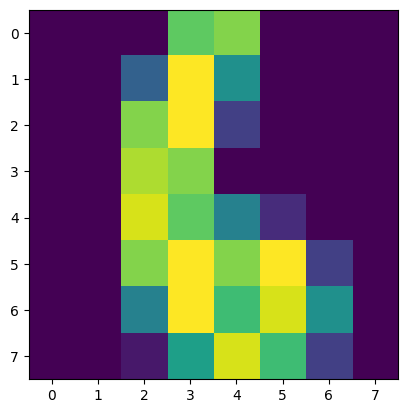

In [8]:
plt.imshow(images[6].reshape(8,8))

In [27]:
dict_learner = DictionaryLearning(
    n_components=64,
    fit_algorithm='cd',
    transform_algorithm= 'omp', 
    random_state=0) 


In [28]:
dict_learner.fit(images[0:100])

DictionaryLearning(fit_algorithm='cd', n_components=64, random_state=0)

In [32]:
ssim_scores = []

for image in tqdm(images):
    reconstructed_image = dict_learner.transform(image.reshape(1,-1)) 
    image = image.reshape(8,8) 
    reconstructed_image = reconstructed_image.reshape(8,8) 
    ssim_score = ssim(image, reconstructed_image, data_range=reconstructed_image.max() - reconstructed_image.min())
    ssim_scores.append(ssim_score)

# Calculate average SSIM
average_ssim = np.mean(ssim_scores)

print("Average SSIM:", average_ssim)

100%|██████████| 1797/1797 [00:01<00:00, 1296.60it/s]

Average SSIM: 2.9224656938283083e-05


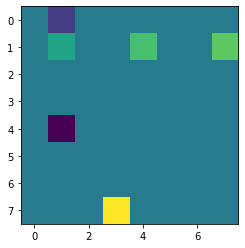

In [33]:
plt.imshow(reconstructed_image)

In [35]:

# OMP parameters
sparsity = 50  # Desired sparsity level

# Perform OMP on each image
ssim_scores = []
for image in tqdm(images):
    approximated_image, selected_indices = orthogonal_matching_pursuit(dict_learner.components_.T, image, sparsity)
    reconstructed_image = np.dot(images.T[:, selected_indices], approximated_image[selected_indices])
    reconstructed_image = reconstructed_image.reshape(8,8) 
    image = image.reshape(8,8) 
    ssim_score = ssim(image, reconstructed_image, data_range=reconstructed_image.max() - reconstructed_image.min())
    ssim_scores.append(ssim_score)

# Calculate average SSIM
average_ssim = np.mean(ssim_scores)

print("Average SSIM:", average_ssim)


100%|██████████| 1797/1797 [00:03<00:00, 585.99it/s]

Average SSIM: 0.00012126993999819036


In [20]:
images.shape

(1797, 64)

In [6]:
labels_reshaped

array([[0],
       [1],
       [2],
       ...,
       [8],
       [9],
       [8]])

In [7]:
predicted_labels

array([[    0,  -434,  1140, ...,  1764, -2952,  -520],
       [    0,   290,  -759, ..., -1166,  1976,   348],
       [    0,   126,  -329, ...,  -493,   864,   151],
       ...,
       [    0,   171,  -445, ...,  -686,  1161,   205],
       [    0,   -86,   228, ...,   361,  -589,  -104],
       [    0,  2671,  6151, ...,  5266,  1101,  -207]])